In [1]:
import numpy as np
from grid2vec import *
import json
import pandas as pd
from utils import Timer
from joblib import Parallel, delayed
from traj2grid import Traj2Grid
import traj_dist.distance as tdist
from parameters import *
import numpy as np

timer = Timer()

#### 生成 Train Dataset 第一步：读取数据


In [2]:
file_path = "data/full/gps_20161101"
dict_path = "data/str_grid2idx_400_44612.json"
nrows = 1000000

# read data
timer.tik("read data")
df = pd.DataFrame(pd.read_csv(file_path, header=None, nrows=nrows))
df.columns = ["name", "id", "time", "lon", "lat"]  # lon经度 lat纬度
timer.tok("read {}".format(file_path))


read data start
read data/full/gps_20161101 done, 0.73s after read data start


#### 生成 Train Dataset 第二步：去除超出范围的数据点


In [3]:
pad = 0.002


l = len(df)
df = df[(df["lon"] > 104.04214 + pad) & (df["lon"] < 104.12958 - pad)]
df = df[(df["lat"] > 30.65294 + pad) & (df["lat"] < 30.72775 - pad)]
print(f"剩{len(df)}/{l}个点，筛掉{round(100 - 100 * len(df) / l)}%")


剩948146/1000000个点，筛掉5%


#### 生成 Train Dataset 第三步：GroupBy转换为1维点列

In [4]:
str_grid2idx = json.load(open(dict_path))
t2g = Traj2Grid(row_num, column_num, min_lon, min_lat, max_lon, max_lat)
grid2idx = {eval(g): str_grid2idx[g] for g in list(str_grid2idx)}
t2g.set_vocab(grid2idx)
timer.tok(f"load dict{dict_path}")


def group_concat(group: pd.DataFrame):
    origin_traj = [((row["lon"]), row["lat"])
                   for index, row in group.iterrows()]
    traj_1d = t2g.convert1d(origin_traj)
    series = pd.Series({
        "origin_trajs": origin_traj,
        "trajs": traj_1d,
        "origin_len": len(origin_traj),
        "len": len(traj_1d),
        "max_lon": group["lon"].max(),
        "max_lat": group["lat"].max(),
        "min_lon": group["lon"].min(),
        "min_lat": group["lat"].min(),
    })
    return series


# group-apply
res = Parallel(n_jobs=44)(delayed(group_concat)(group)for name, group in df.groupby("id"))
df = pd.DataFrame(res)
timer.tok("group-apply")


load dictdata/str_grid2idx_400_44612.json done, 1.266s after read data start
group-apply done, 66.416s after read data start


##### 看看数据情况

count    5485.000000
mean      103.222060
std        72.892705
min         1.000000
25%        47.000000
50%        92.000000
75%       144.000000
max       583.000000
Name: len, dtype: float64

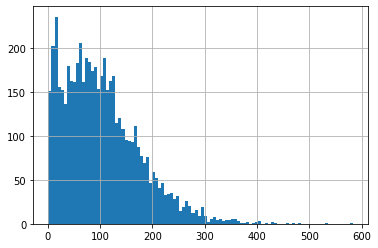

In [5]:
df['len'].hist(bins=100)
df['len'].describe()

#### 生成 Train Dataset 第四步：过滤过长过短轨迹

In [6]:
l = len(df)
df = df[(df["len"] > 10) & (df["len"] < 256)]
print(f"剩{len(df)}/{l}条轨迹，筛掉{round(100 - 100 * len(df) / l)}%")


剩5006/5485条轨迹，筛掉9%


#### 生成 Train Dataset 第五步：生成轨迹距离矩阵


In [7]:
origin_trajs = df["origin_trajs"].to_list()
arr = [np.array(origin_traj) for origin_traj in origin_trajs]
length = len(arr)
dis_matrix = np.zeros((length, length))
dis_func = getattr(tdist, "discret_frechet")

def cal_dis(i, j, x, y, n):
    dis = dis_func(x, y)
    if i % 100 == 0 and i == j + 1:
        timer.tok(f'{i}-{round((i * i) / (n * n) * 100, 2)}%')
    return i, j, dis


res = Parallel(n_jobs=44)(
    delayed(cal_dis)(i, j, arr[i], arr[j], length - 1) for i in range(length) for j in range(i))
timer.tok("calculate distance")
for (i, j, dis) in res:
    dis_matrix[i, j] = dis
    dis_matrix[j, i] = dis


100-0.04% done, 69.236s after read data start
200-0.16% done, 70.947s after read data start
300-0.36% done, 73.451s after read data start
400-0.64% done, 76.742s after read data start
500-1.0% done, 81.024s after read data start
600-1.44% done, 87.327s after read data start
700-1.96% done, 94.256s after read data start
800-2.55% done, 103.416s after read data start
900-3.23% done, 111.835s after read data start
1000-3.99% done, 122.844s after read data start
1100-4.83% done, 133.489s after read data start
1200-5.75% done, 145.373s after read data start
1300-6.75% done, 156.605s after read data start
1400-7.82% done, 168.458s after read data start
1500-8.98% done, 180.245s after read data start
1600-10.22% done, 193.541s after read data start
1700-11.54% done, 208.815s after read data start
1800-12.93% done, 225.185s after read data start
1900-14.41% done, 243.246s after read data start
2000-15.97% done, 265.4s after read data start
2100-17.6% done, 287.499s after read data start
2200-1

#### 生成 Train Dataset 第六步：排序

In [8]:
sorted_index = np.argsort(dis_matrix, axis=1)

#### 生成 Train Dataset 第七步：保存

In [10]:
full = True


dict_save = {'trajs': df["trajs"].to_list(), "sorted_index": sorted_index.tolist(), 'origin_trajs': origin_trajs}
if full:
    dict_save["dis_matrix"] = dis_matrix.tolist()
    json.dump(dict_save, open(file_path + f"_{sorted_index.shape[0]}_dataset_full.json", "w"))
else:
    json.dump(dict_save, open(file_path + f"_{sorted_index.shape[0]}_dataset_small.json", "w"))
timer.tok("save")


save done, 2337.311s after read data start
